# AMATH 563 Homework 1
## Rachel Carroll
### 4/17/2020

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from matplotlib.ticker import PercentFormatter

In [2]:
###### Modeling Functions ######
# Returns six X matrices using the various solvers selected for this project
def x_solvers(A,B):
    #Using pseudo inverse
    X_pi = np.linalg.pinv(A) @ B
    #Using least square
    X_ls = np.linalg.lstsq(A,B,rcond=None)[0]
    #ridge
    ridge = linear_model.Ridge(alpha=1.0).fit(A, B)
    X_ridge = ridge.coef_
    X_ridge=X_ridge.transpose()
    #elastic net
    X_e1 = linear_model.ElasticNet(alpha=1.5, copy_X=True, l1_ratio=.6, max_iter=10**5,random_state=0).fit(A, B).coef_
    X_e1=X_e1.transpose()   
    #Lasso low alpha
    X_lasso = linear_model.Lasso(alpha=2).fit(A, B).coef_
    X_lasso=X_lasso.T
    #Lasso2 high alpha
    X_lasso2 = linear_model.Lasso(alpha=5).fit(A, B).coef_
    X_lasso2=X_lasso2.T
    
    return X_pi, X_ls, X_ridge, X_e1, X_lasso, X_lasso2

"""
sorts relevant pixels. 
If labelnum="" the relevant pixels will be based on the L2 norm average column of X.
If labelnum is a digit from 0 to 9 the order will be based on significant pixels for that specific digit

returns 
sorted_pixels - is a vector with pixel numbers in order of significance
sorted_col - the absoute value of the coefficient from largest to smallest
"""
def order_x_col(X, labelnum=""):    
    if labelnum=="":
        col = np.sum(np.abs(X)**2,axis=1)**(1./2)
    else:
        number_indx=(int(labelnum)-1) % 10
        col=X[:,number_indx]
        
    abs_col= -abs(col)
    sorted_pixels=abs_col.argsort()
    sorted_col=col[sorted_pixels]
    return sorted_pixels, sorted_col 

#runs the order_x_col function for all solution matrices used in this experiement. 
#returns only the ordered pixels, not their associated coeffs
def order_pix_all_x (labelnum=""):        
    pi_ord_pixel_nums = order_x_col(X_pi,labelnum)[0]
    ls_ord_pixel_nums = order_x_col(X_ls,labelnum)[0]
    ridge_ord_pixel_nums = order_x_col(X_ridge,labelnum)[0]
    e1_ord_pixel_nums = order_x_col(X_e1,labelnum)[0]
    lasso_ord_pixel_nums = order_x_col(X_lasso,labelnum)[0]
    lasso2_ord_pixel_nums = order_x_col(X_lasso2,labelnum)[0]
    return pi_ord_pixel_nums,ls_ord_pixel_nums,ridge_ord_pixel_nums,e1_ord_pixel_nums,lasso_ord_pixel_nums,lasso2_ord_pixel_nums

""""
Uses given set of image data (A), and desired solver (X), a list of pixel numbers of interest(selected pixels), and digit
if labelnum="" it runs the model to label each digit 
if labelnum is a digit it runs a boolean model that identifies if the image is a desired digit or not
""""
def image_label_model(A, X, selected_pixels, labelnum = ""):
    #create subtest matrices only include desired pixels/digit
    A_1=A[:,selected_pixels]
    X=X[selected_pixels,:]
    n=A_1.shape[0] # number of images    
    if labelnum !="": #if a digit is specified, X becomes a vector of coefficients associated with that digit
        number_indx=(int(labelnum)-1) % 10
        X=X[:,number_indx]
    
    #apply the map (X) to bring pixel data to "label space" (predict_matrix) 
    #which is a vector is a digit is specified of an nx10 matrix if labeling all digits
    predict_matrix=A_1 @ X
    
    #use predict_matrix to create a vector of labels
    if labelnum =="": #if all digits are to be labeled
        predicted_labels=[]
        for i in range(n): #loop through  images
            label_predict_vec=predict_matrix[i].tolist() #vector of length 10
            max_val=max(label_predict_vec) #find max value of the vector
            predicted_label=(label_predict_vec.index(max_val)+1)%10 #find predicted label based on the location of the max value
            predicted_labels.append(predicted_label) #store predicted values in a list to compare with true values
        predicted_labels=np.asarray(predicted_labels)
    else: #if a digits is specified
        predicted_labels= predict_matrix>=.5 #criteria is that the associated image is the digit in question if the value is closer to 1 than 0
    return predicted_labels

#calculated error between predicted labels and true labels. if a digit is secified, the true label vector is transformed into a boolean first
def model_errors(predicted_labels,true_labels, labelnum = ""):
    n=len(predicted_labels)
    if labelnum == "":
        percent_accuracy=sum(true_labels==predicted_labels)/n
        percent_error=1-percent_accuracy
    else:
      #predicted_labels=predicted_labels==int(labelnum)
        true_labels=true_labels==int(labelnum)   
        percent_accuracy=sum(true_labels==predicted_labels)/n
        percent_error=1-percent_accuracy
    return percent_error

"""
Runs model and stores errors in a vector for each type of X matrix used in this analysis.
The returned vectors contain an error rate for each given pixel count value (from pixel_counts).
""""
def error_pixel(A, true_labels, pixel_counts, labelnum=""):   
    #create pixel significance order vectors
    pi_ord_pixel_nums,ls_ord_pixel_nums, \
    ridge_ord_pixel_nums,e1_ord_pixel_nums,\
    lasso_ord_pixel_nums,lasso2_ord_pixel_nums=order_pix_all_x(labelnum)
    #initialize error vectors for each solver type
    pi_error_vec=[]
    ls_error_vec=[]
    ridge_error_vec=[]
    e1_error_vec=[]
    lasso_error_vec=[]
    lasso2_error_vec=[]
    for i in pixel_counts: #loop through given vector pixel_counts
        pi_p_labs = image_label_model(A, X_pi, pi_ord_pixel_nums[0:i],labelnum) #runs model using the i most important pixels
        pi_error = model_errors(pi_p_labs,true_labels, labelnum) #gets error
        pi_error_vec.append(pi_error) #append error vector with the error associated with the number of pixels used

        ls_p_labs = image_label_model(A, X_ls, ls_ord_pixel_nums[0:i],labelnum)
        ls_error = model_errors(ls_p_labs,true_labels, labelnum)
        ls_error_vec.append(ls_error)

        ridge_p_labs = image_label_model(A, X_ridge, ridge_ord_pixel_nums[0:i],labelnum)
        ridge_error = model_errors(ridge_p_labs,true_labels, labelnum)
        ridge_error_vec.append(ridge_error)

        e1_p_labs = image_label_model(A, X_e1, e1_ord_pixel_nums[0:i],labelnum)
        e1_error = model_errors(e1_p_labs,true_labels, labelnum)
        e1_error_vec.append(e1_error)

        lasso_p_labs = image_label_model(A, X_lasso, lasso_ord_pixel_nums[0:i],labelnum)
        lasso_error = model_errors(lasso_p_labs,true_labels, labelnum)
        lasso_error_vec.append(lasso_error)

        lasso2_p_labs = image_label_model(A, X_lasso2, lasso2_ord_pixel_nums[0:i],labelnum)
        lasso2_error = model_errors(lasso2_p_labs,true_labels, labelnum)
        lasso2_error_vec.append(lasso2_error)
    return pi_error_vec, ls_error_vec,ridge_error_vec,e1_error_vec,lasso_error_vec,lasso2_error_vec


###### Plotting Functions ######
#plots each column of X to show the significant pixels for each digit
def plot_all_col_coeffs(X,solve_type):
    for i in range(10): #loop through columns to plot.
        x_col=(X[:,i]) 
        plt.plot(x_col,'*', label = 'digit ' +str((i+1)%10))
    plt.legend(bbox_to_anchor=(1.0, 1.02))
    plt.ylabel("value")
    plt.xlabel("pixel")
    plt.title(solve_type , y=1)
    plt.tight_layout()
    
#plots bar graph of the (L2norm) average column of matrix X to demonstrate sparcity of the solution overall
def bar_2norm_coeffs(X,solve_type):
    avg_x_col=np.sum(np.abs(X)**2,axis=1)**(1./2)  # this computes L2 norm mean
    nonzero_count=len(avg_x_col[avg_x_col!=0]) #this calculates the number of nonzero elements
    
    plt.bar(range(len(avg_x_col)),avg_x_col)
    plt.ylabel("coefficient value")
    plt.xlabel("pixel number")

    plt.title(solve_type + "\n nonzero count: %d" % nonzero_count , y=1)
    plt.tight_layout()

### Part 1 Read and Prepare Data
##### Read in TRAINING image and  labels

In [3]:
train_im_file = gzip.open('data/train-images-idx3-ubyte.gz','r')

train_image_size = 28 #images are 28 by 28 pixels
train_num_images = 60000 #there are 6000 training images

train_im_file.read(16) #using 16 because per the file information, the first pixel bytes occur at 16
buf = train_im_file.read(train_image_size * train_image_size * train_num_images)
train_image_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
train_image_data = train_image_data.reshape(train_num_images, train_image_size, train_image_size, 1)


train_lab_file = gzip.open('data/train-labels-idx1-ubyte.gz','r')
train_lab_file.read(8)

train_labels=[]
for i in range(0,train_num_images):   
    buf = train_lab_file.read(1)
    train_labels.append(int(np.frombuffer(buf, dtype=np.uint8).astype(np.int64)))
train_labels=np.array(train_labels)

##### Read in TEST image and  labels

In [4]:
test_im_file = gzip.open('data/t10k-images-idx3-ubyte.gz','r')

test_image_size = 28 #images are 28 by 28 pixels
test_num_images = 10000 #there are 10000 test images

test_im_file.read(16) #using 16 because per the file information, the first pixel bytes occur at 16
buf = test_im_file.read(test_image_size * test_image_size * test_num_images)
test_image_data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
test_image_data = test_image_data.reshape(test_num_images, test_image_size, test_image_size, 1)


test_lab_file = gzip.open('data/t10k-labels-idx1-ubyte.gz','r')
test_lab_file.read(8)

test_labels=[]
for i in range(0,test_num_images):   
    buf = test_lab_file.read(1)
    test_labels.append(int(np.frombuffer(buf, dtype=np.uint8).astype(np.int64)))
test_labels=np.array(test_labels)

#### Create matrix A (for training)

In [5]:
A = np.empty((60000,784))
for i in range(60000):
    image = np.asarray(train_image_data[i]).squeeze()
    image_vec=image.reshape(784,)
    A[i]=image_vec

In [6]:
A.shape

(60000, 784)

#### Create Matrix B (training)

In [7]:
B = np.empty((60000,10))
for indx in range(60000):
    vec=np.zeros((10))
    lab=train_labels[indx]
    vec[lab-1]=1
    B[indx]=vec

In [8]:
B.shape

(60000, 10)

#### Create Matrix A_test (for testing)

In [9]:
A_test = np.empty((10000,784))
for i in range(10000):
    image = np.asarray(test_image_data[i]).squeeze()
    image_vec=image.reshape(784,)
    A_test[i]=image_vec

In [10]:
A_test.shape

(10000, 784)

train cooresponding label 1
test cooresponding label 0


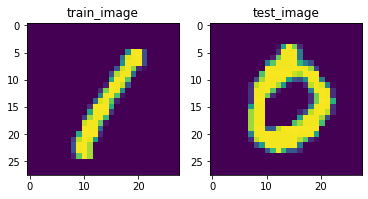

In [11]:
#check for consistant labels
fig, axs = plt.subplots(1,2)


indx=3
train_image = A[indx,:].reshape(28,28)
axs[0].imshow(train_image); axs[0].set_title('train_image')

test_image = A_test[indx,:].reshape(28,28)
axs[1].imshow(test_image); axs[1].set_title('test_image')

print("train cooresponding label",train_labels[indx])
print("test cooresponding label",test_labels[indx])


### Part 2 Analyze mappings from the image space (A) to the label space (B) using different solvers

##### Create X matrix for various solvers
The solution matrix X will be a 784 by 10 matrix, each of its columns will give the relative importance of the 784 pixels in identifying the associated label

In [12]:
# using x_solvers function to create X matrix using pseudoinvers, least square, ridge, elasticnet, and lasso
X_pi, X_ls, X_ridge, X_e1, X_lasso, X_lasso2=x_solvers(A,B)

##### Create colormap of all mappings (X) to establish overall sparcity/significant pixels

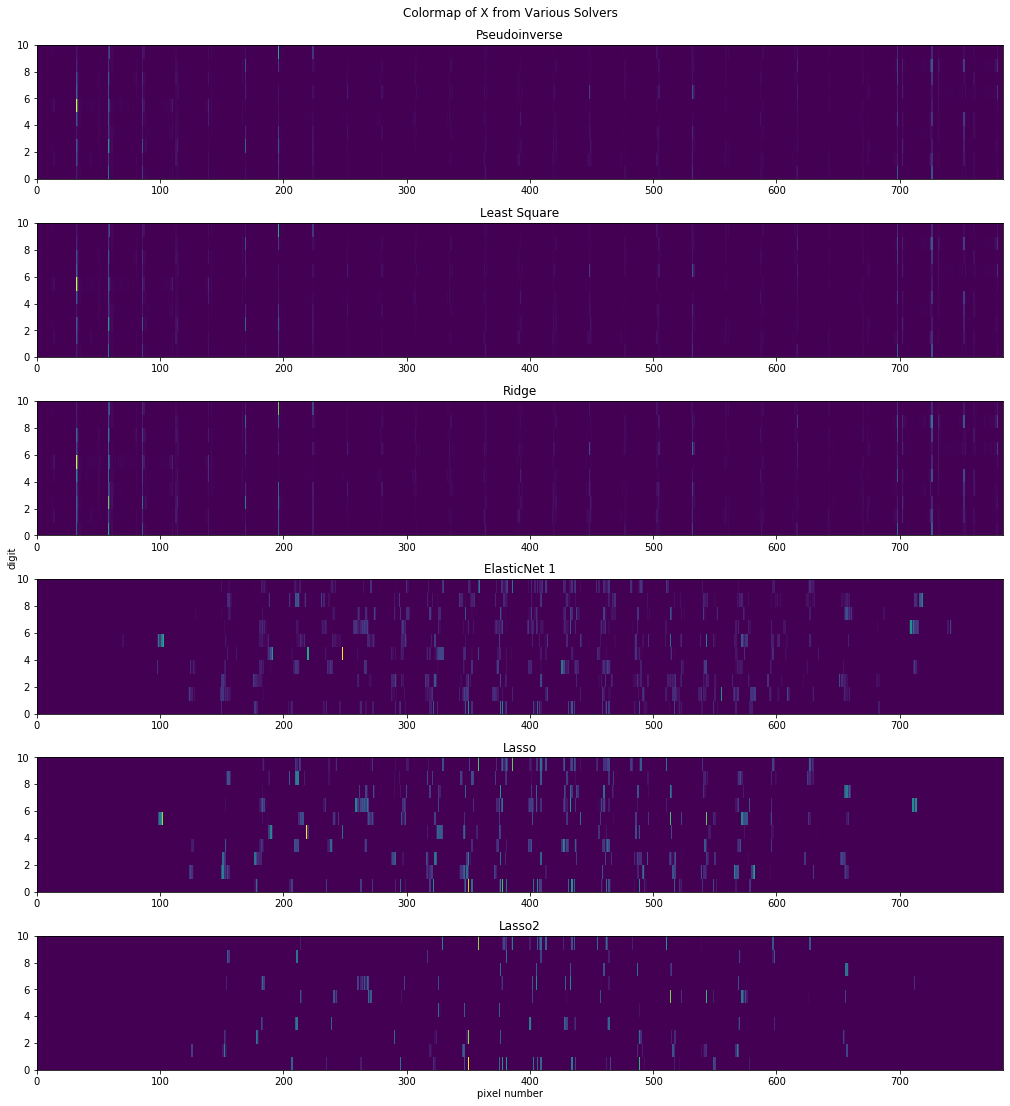

In [13]:
fig, axs = plt.subplots(6,1,figsize=(14,15))

fig.suptitle("Colormap of X from Various Solvers", y=1.01)

axs[0].pcolor(abs(X_pi).transpose()); axs[0].set_title("Pseudoinverse")
axs[1].pcolor(abs(X_ls).transpose()); axs[1].set_title("Least Square")
axs[2].pcolor(abs(X_ridge).transpose()); axs[2].set_title("Ridge")
axs[3].pcolor(abs(X_e1).transpose()); axs[3].set_title("ElasticNet 1")
axs[4].pcolor(abs(X_lasso).transpose()); axs[4].set_title("Lasso")
axs[5].pcolor(abs(X_lasso2).transpose()); axs[5].set_title("Lasso2")

fig.text(0.5, 0.001, 'pixel number', ha='center')
fig.text(0.001, 0.5, 'digit', va='center', rotation='vertical')

plt.tight_layout()

plt.savefig("colormap_X",bbox_inches='tight')

Notice that pseudoinverse, pi, and ridge look very similar. The stright lines indicate the the relevant pixels are similar for all digits. Also there seems to be a strong distinction between relevant and non relevant pixels given the lack of medium hues. 

ElasticNet Lasso and Lasso2 also have similar patterns of behavior in terms of relevant pixels, but differ from the first three. This makes sense because these models introduce L1 regularization. However they do differ in contrast between significant and less significant pixels due to the different weights associated with the regularization. As expected, Lasso2, which penalizes the L1 norm the most, looks the most sparce.

Overall sparcity is difficult to establish because the purple area may be zero or very small numbers. The next image will determine sparcity more percisely.

##### Identify important pixels

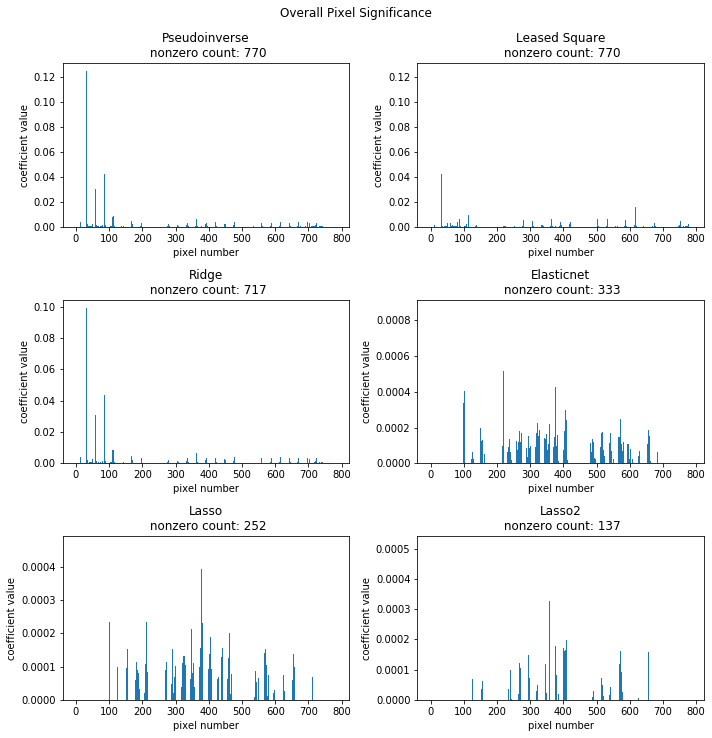

In [14]:
#Look at sparcity of different models
plt.figure(figsize=(10,10))
plt.subplot(3,2,1); bar_2norm_coeffs(X_pi,'Pseudoinverse')
plt.subplot(3,2,2); bar_2norm_coeffs(X_ls,'Leased Square')
plt.subplot(3,2,3); bar_2norm_coeffs(X_ridge,'Ridge')
plt.subplot(3,2,4); bar_2norm_coeffs(X_e1,'Elasticnet')
plt.subplot(3,2,5); bar_2norm_coeffs(X_lasso,'Lasso')
plt.subplot(3,2,6); bar_2norm_coeffs(X_lasso2,'Lasso2')
plt.suptitle ("Overall Pixel Significance", y=1.02)

plt.savefig("overall_pix_coeffs",bbox_inches='tight')

This image demonstrates the sparicty of each model. As expected we see that sparcity increases as the L1 norm is more highly weighted. 

### Part 3 Run Models on Training Data

##### Plot error rate by number of pixels used to determine optimal number of pixels and solver type


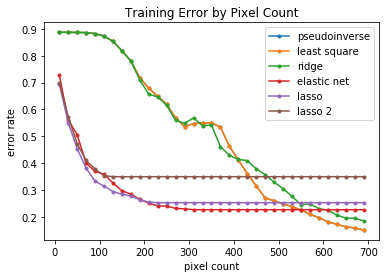

In [16]:
# Run model with a range of pixel nums for each solver type and plot errors to find optimal model and pixel count
# pixel number ranked by importance (based on l2 norm of associated coefficients) for each solver

pixel_counts=np.asarray(range(10,700,20)) #get error when using 10, 30, 50,...pixels

#run model and get errors of results using error_pixel()
pi_error_vec,ls_error_vec,ridge_error_vec, \
e1_error_vec,lasso_error_vec,lasso2_error_vec = error_pixel(A,train_labels, pixel_counts, labelnum="")

#plot results
plt.plot(pixel_counts,pi_error_vec,'.-', label='pseudoinverse')
plt.plot(pixel_counts,ls_error_vec,'.-', label='least square')
plt.plot(pixel_counts,ridge_error_vec,'.-', label='ridge')
plt.plot(pixel_counts,e1_error_vec,'.-', label='elastic net')
plt.plot(pixel_counts,lasso_error_vec,'.-', label='lasso')
plt.plot(pixel_counts,lasso2_error_vec,'.-',label='lasso 2')

plt.xlabel("pixel count")
plt.ylabel("error rate")
plt.title("Training Error by Pixel Count")
plt.legend()

plt.savefig("Training_error_by_pixel")

From the plot above, the lasso model (which uses alpha=2) and elasticnet model perform well. The lasso2 model starts off well with the error dropping quickly, however it tapers off just after 100 pixels which makes sense because there are only 137 nonzero coefficients.

The pseudoinverse, least square, and ridge are far less sparce meaning they cannot grasp a lot of imformation from ony a few pixels. However, these models end up with lower error overall when using all pixels. This is only marginal however. elasticnet and lasso reach 25% error by 200 pixels while it takes pseudoinverse, least square, and ridge around 550 pixels to reach that level.

### Part 4 Test Model
From above, the best models in terms of using fewer pixels are Elastic net, Lasso, and Lasso2. We will focus on these three on the test data.

In [54]:
#chose how many pixels to use
pixel_counts=np.asarray([50,100,150])

#run model and get error vectors from TRAINING data
train_e1_error_vec, \
train_lasso_error_vec, \
train_lasso2_error_vec = error_pixel(A, train_labels, pixel_counts, labelnum="")[3:6]

#run model and get error vectors from TEST data
test_e1_error_vec, \
test_1asso_error_vec, \
test_lasso2_error_vec = error_pixel(A_test, test_labels, pixel_counts, labelnum="")[3:6]


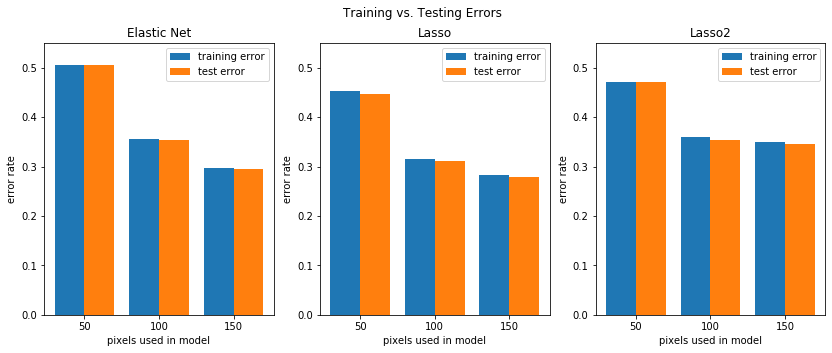

In [56]:
#Plot train and test results for both models
X = list(map(str,pixel_counts))
_X = np.arange(len(X))

plt.figure(figsize=(14,5))

plt.subplot(131)
plt.bar(_X - 0.2, train_e1_error_vec, 0.4, label='training error')
plt.bar(_X + 0.2, test_e1_error_vec, 0.4, label='test error')
plt.xticks(_X, X);plt.ylim(0,.55); plt.ylabel("error rate"); plt.xlabel("pixels used in model");plt.legend()
plt.title("Elastic Net")

plt.subplot(132)
plt.bar(_X - 0.2, train_lasso_error_vec, 0.4, label='training error')
plt.bar(_X + 0.2, test_1asso_error_vec, 0.4, label='test error')
plt.xticks(_X, X);plt.ylim(0,.55); plt.ylabel("error rate"); plt.xlabel("pixels used in model");plt.legend()
plt.title("Lasso")

plt.subplot(133)
plt.bar(_X - 0.2, train_lasso2_error_vec, 0.4, label='training error')
plt.bar(_X + 0.2, test_lasso2_error_vec, 0.4, label='test error')
plt.xticks(_X, X); plt.ylim(0,.55); plt.ylabel("error rate"); plt.xlabel("pixels used in model");plt.legend()
plt.title("Lasso2")

plt.suptitle('Training vs. Testing Errors')
plt.savefig("train_test_errors")

for all three models, the test results are very close to the training results meaning the models are fitting the data patterns well.

### Part 5 Repeat for specific numbers 



In [57]:
def number_specific_model(number,train_test_pixels):
    number_indx=(int(number)-1) % 10
    
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    pi_ord_pixel_nums,ls_ord_pixel_nums, \
    ridge_ord_pixel_nums,e1_ord_pixel_nums,\
    lasso_ord_pixel_nums,lasso2_ord_pixel_nums=order_pix_all_x(number)
    

    pixel_counts=np.asarray(range(5,300,10))
    pi_error_vec,ls_error_vec,ridge_error_vec, \
    e1_error_vec,lasso_error_vec,lasso2_error_vec = error_pixel(A, train_labels, pixel_counts, labelnum=number)

    plt.plot(pixel_counts,pi_error_vec,'.-', label='pseudoinverse')
    plt.plot(pixel_counts,ls_error_vec,'.-', label='least square')
    plt.plot(pixel_counts,ridge_error_vec,'.-', label='ridge')
    plt.plot(pixel_counts,e1_error_vec,'.-', label='elastic net')
    plt.plot(pixel_counts,lasso_error_vec,'.-', label='lasso')
    plt.plot(pixel_counts,lasso2_error_vec,'.-',label='lasso 2')

    plt.xlabel("pixel count");plt.ylabel("error rate");plt.legend(loc='upper right')
    plt.title("Training Error by Pixel Count")
    
    #####Subplot 2
    plt.subplot(1,3,2)
    plt.bar(range(len(X_e1[:,number_indx])),abs(X_e1[:,number_indx]), label="elastic net")
    plt.xlabel("value");plt.ylabel("value");plt.title("ElasticNet Model Coefficients")
    
    ###Subplot 3
    plt.subplot(1,3,3)
    
    train_e1_error_vec=[]
    test_e1_error_vec=[]
    for i in train_test_pixels:
        #get training errors
        train_e1_p_labs = image_label_model(A, X_e1, e1_ord_pixel_nums[0:i],number)
        train_e1_error = model_errors(train_e1_p_labs,train_labels,labelnum = number)
        #get testing errors
        test_e1_p_labs = image_label_model(A_test, X_e1, e1_ord_pixel_nums[0:i],number)
        test_e1_error = model_errors(test_e1_p_labs,test_labels,labelnum = number)

        train_e1_error_vec.append(train_e1_error)
        test_e1_error_vec.append(test_e1_error)
        
    X = list(map(str,train_test_pixels))
    _X = np.arange(len(X))
    plt.bar(_X - 0.2, train_e1_error_vec, 0.4, label='training error')
    plt.bar(_X + 0.2, test_e1_error_vec, 0.4, label='test error')
    plt.xticks(_X, X); plt.ylabel("error rate"); plt.xlabel("pixels used in model");plt.legend(loc='upper right')
    plt.title("ElasticNet Training and Testing Errors")

    #title
    plt.suptitle("Number %s" %number, y=1.01)
    plt.tight_layout()


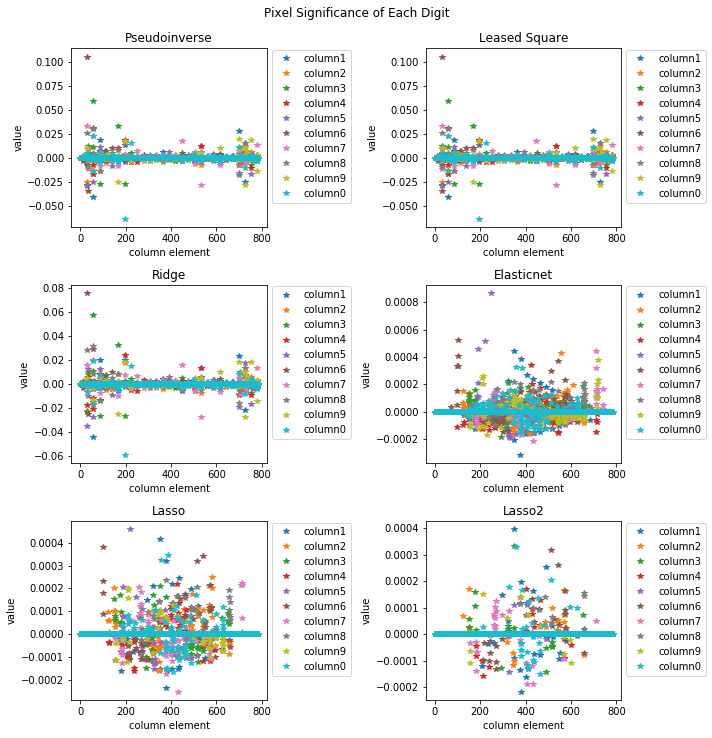

In [23]:
# plot
plt.figure(figsize=(10,10))
plt.subplot(3,2,1); plot_all_col_coeffs(X_pi,'Pseudoinverse')
plt.subplot(3,2,2); plot_all_col_coeffs(X_ls,'Leased Square')
plt.subplot(3,2,3); plot_all_col_coeffs(X_ridge,'Ridge')
plt.subplot(3,2,4); plot_all_col_coeffs(X_e1,'Elasticnet')
plt.subplot(3,2,5); plot_all_col_coeffs(X_lasso,'Lasso')
plt.subplot(3,2,6); plot_all_col_coeffs(X_lasso2,'Lasso2')
plt.suptitle ("Pixel Significance of Each Digit", y=1.02)

plt.savefig("pixel_coeff_by_digit")

#### Number Specific Plots

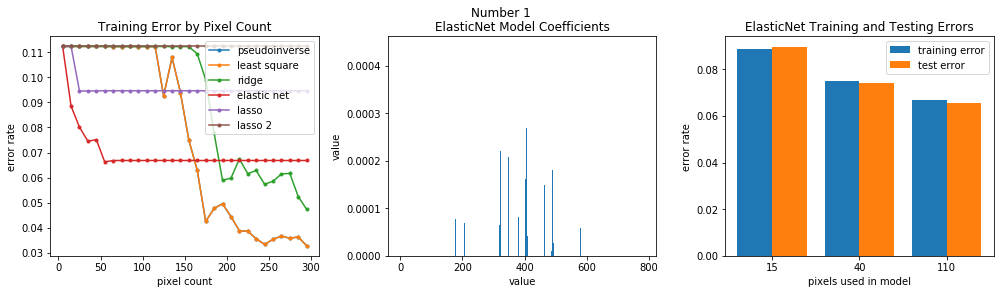

In [58]:
test_train_bar_pix=[15,40,110]

number_specific_model("1",test_train_bar_pix)
plt.savefig("1_plots",bbox_inches='tight')

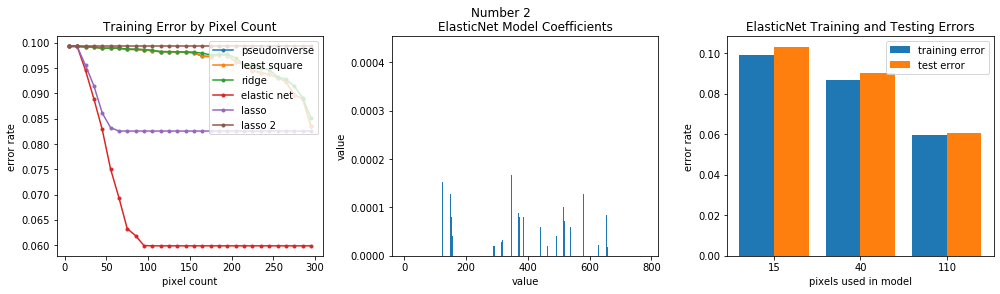

In [59]:
number_specific_model("2",test_train_bar_pix)
plt.savefig("2_plots",bbox_inches='tight')

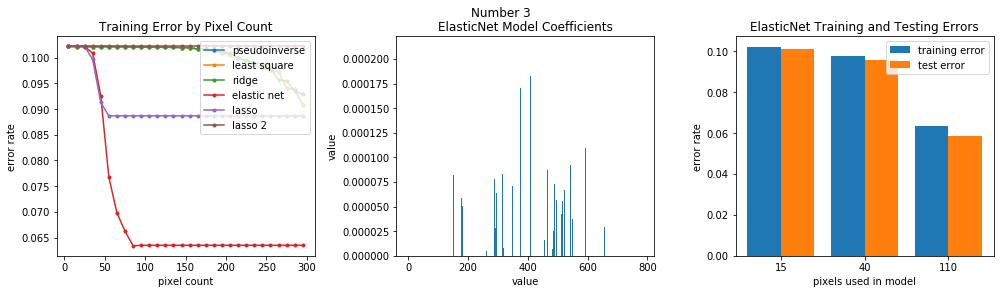

In [60]:
number_specific_model("3",test_train_bar_pix)
plt.savefig("3_plots",bbox_inches='tight')

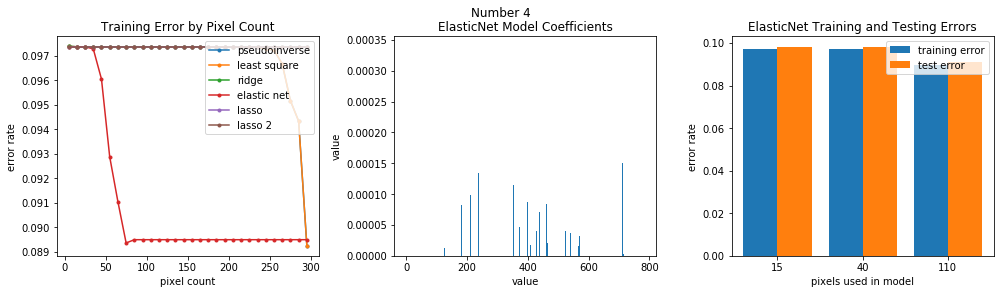

In [61]:
number_specific_model("4",test_train_bar_pix)
plt.savefig("4_plots",bbox_inches='tight')

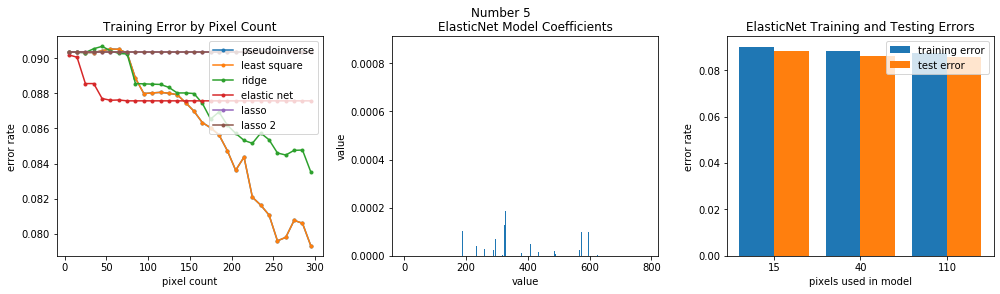

In [62]:
number_specific_model("5",test_train_bar_pix)
plt.savefig("5_plots",bbox_inches='tight')

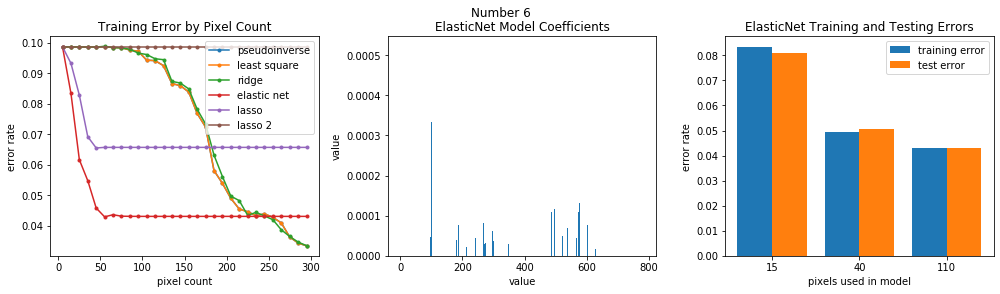

In [63]:
number_specific_model("6",test_train_bar_pix)
plt.savefig("6_plots",bbox_inches='tight')

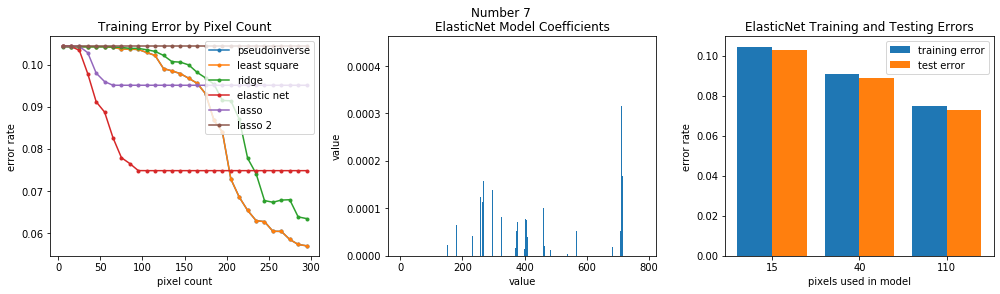

In [64]:
number_specific_model("7",test_train_bar_pix)
plt.savefig("7_plots",bbox_inches='tight')

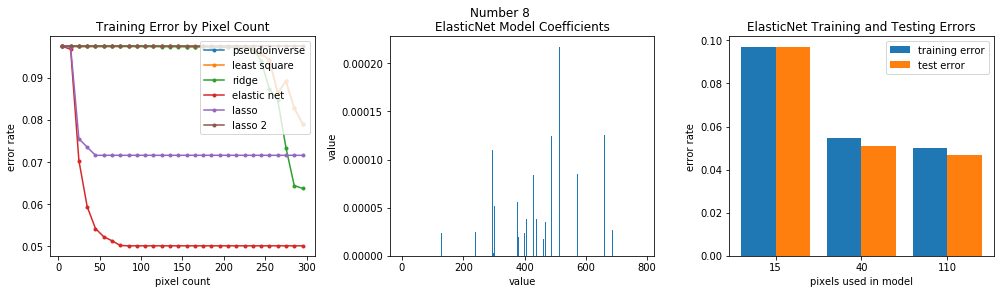

In [65]:
number_specific_model("8",test_train_bar_pix)
plt.savefig("8_plots",bbox_inches='tight')

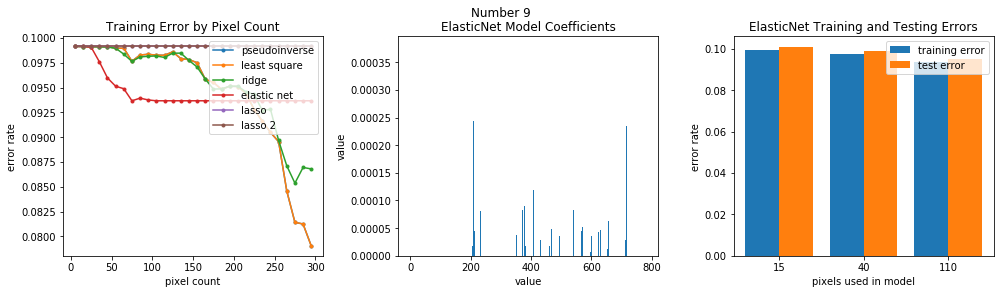

In [66]:
number_specific_model("9",test_train_bar_pix)
plt.savefig("9_plots",bbox_inches='tight')

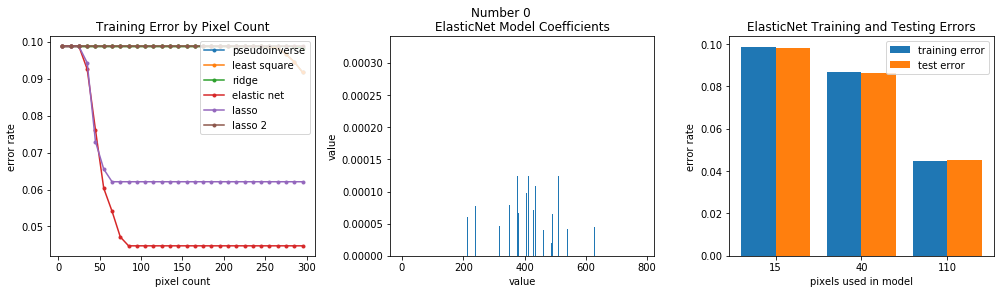

In [67]:
number_specific_model("0",test_train_bar_pix)
plt.savefig("0_plots",bbox_inches='tight')